<h1 alingn='center'> USA - Road Accident Traffic Delay Severity Prediction </h1>

## Import Libraries

In [72]:
import pandas as pd # pandas
import numpy as np # numpy
%matplotlib inline

# below libraries are used for plotting charts
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns 
mpl.style.use('ggplot') # optional: for ggplot-like style

In [74]:
#library used generate map

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [75]:
collist = [
'ID','Source','TMC','Severity','Start_Time','End_Time','Start_Lat','Start_Lng','End_Lat','End_Lng','Distance(mi)',
'Description','Number','Street','Side','City','County','State','Zipcode','Country','Timezone','Airport_Code',
'Weather_Timestamp','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Direction',
'Wind_Speed(mph)','Precipitation(in)','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit',
'Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight',
'Nautical_Twilight','Astronomical_Twilight'
]

df = pd.read_csv('US_Accidents_2019.csv', usecols = collist)

df_temp = df[['Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'Temperature(F)', 'Weather_Condition', 'Wind_Direction', 'Wind_Chill(F)', 'Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)', 'City', 'State','Bump', 'Crossing','Junction', 'Roundabout', 'Stop']]
df_temp.head(2)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Temperature(F),Weather_Condition,Wind_Direction,Wind_Chill(F),Humidity(%),...,Visibility(mi),Wind_Speed(mph),Precipitation(in),City,State,Bump,Crossing,Junction,Roundabout,Stop
0,3,2019-12-26 17:09:52,2020-01-10 11:00:00,40.884850,-95.800362,31.0,Fair,CALM,31.0,85.0,...,10.0,0.0,0.0,Thurman,IA,False,False,False,False,False
1,3,2019-12-26 17:10:32,2020-01-10 11:00:00,40.889641,-95.798630,31.0,Fair,CALM,31.0,85.0,...,10.0,0.0,0.0,Thurman,IA,False,False,False,False,False


In [76]:
df.shape

(797298, 49)

The dataset is having lots of null values on various column. Hence filtered the null values from the dataset

The Wind Direction is having duplicate values like East&E, West&W, North&N, South&S. Replaced the values with E,W,N&S respectively

In [77]:
accdf = df_temp[(~df_temp['Weather_Condition'].isnull() & 
                 ~df_temp['Wind_Speed(mph)'].isnull() & 
                 ~df_temp['Temperature(F)'].isnull() & 
                 ~df_temp['Humidity(%)'].isnull() & 
                 ~df_temp['Visibility(mi)'].isnull() & 
                 ~df_temp['Pressure(in)'].isnull() & 
                 ~df_temp['Wind_Direction'].isnull() & 
                 ~df_temp['Precipitation(in)'].isnull() & 
                 ~df_temp['Wind_Chill(F)'].isnull() )]

type_change = {'Bump':int, 'Crossing':int, 'Junction':int,'Roundabout':int,  'Stop':int}
accdf = accdf.astype(type_change)
accdf['Wind_Direction'].replace({'East':'E','West':'W','South':'S','North':'N'}, inplace=True)
accdf['Start_Hr_Min'] = pd.to_datetime(accdf['Start_Time']).dt.hour
print(accdf.shape)
accdf.head(3)

(700257, 22)


,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Temperature(F),Weather_Condition,Wind_Direction,Wind_Chill(F),Humidity(%),...,Wind_Speed(mph),Precipitation(in),City,State,Bump,Crossing,Junction,Roundabout,Stop,Start_Hr_Min
0,3,2019-12-26 17:09:52,2020-01-10 11:00:00,40.884850,-95.800362,31.0,Fair,CALM,31.0,85.0,...,0.0,0.0,Thurman,IA,0,0,0,0,0,17
1,3,2019-12-26 17:10:32,2020-01-10 11:00:00,40.889641,-95.798630,31.0,Fair,CALM,31.0,85.0,...,0.0,0.0,Thurman,IA,0,0,0,0,0,17
2,3,2019-12-31 23:49:36,2020-01-01 01:27:09,42.313499,-83.091225,28.0,Cloudy,WSW,17.0,92.0,...,13.0,0.0,Detroit,MI,0,0,0,0,0,23


In [78]:
accdf_city = accdf.groupby(['Severity','State','City']).agg(SeverityCount = ('Severity','count')
                    , Lat = ('Start_Lat','max')
                    , Lan = ('Start_Lng','max')).reset_index().sort_values('SeverityCount', ascending=False)

df_map = accdf_city[accdf_city['SeverityCount']> 100]
us_city_map = folium.Map(location=[39.75, -84.23], zoom_start=4)

for Lat, Lng, sev, cnt, state, city in zip (df_map['Lat'] , df_map['Lan'], df_map['Severity']  , df_map['SeverityCount'] ,df_map['State']   ,df_map['City']):
    label = 'State: {}, City: {}, Severity: {}, Accident Count: {}'.format(state, city, sev,cnt)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Lat, Lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(us_city_map)  
    
# display world map
us_city_map

In [79]:
accdf_city

,Severity,State,City,SeverityCount,Lat,Lan
5257,2,NC,Charlotte,15278,35.391026,-80.570168
9062,2,TX,Houston,12746,30.029045,-95.133965
1136,2,CA,Los Angeles,11891,34.156310,-118.123697
8943,2,TX,Austin,11716,30.513420,-97.554733
7304,2,OK,Oklahoma City,8226,35.623718,-97.264999
...,...,...,...,...,...,...
11409,3,FL,Lake Wales,1,27.893946,-81.564667
11402,3,FL,Key Biscayne,1,25.746580,-80.179030
11401,3,FL,Kenansville,1,27.995859,-81.133736
11395,3,FL,Islamorada,1,24.855761,-80.729881


In [80]:
#df_sev = accdf.groupby('Severity').agg(Traffice_Severity=('Severity','count')).reset_index().sort_values('Traffice_Severity', ascending=False)
df_sev = accdf.groupby('Severity').agg ( Severity_Count = ('Severity', 'count')).reset_index().sort_values('Severity_Count')
df_sev = df_sev[['Severity','Severity_Count']].sort_values('Severity_Count',ascending=False).set_index('Severity')

In [81]:
df_sev

,Severity_Count
Severity,
2,511665
3,168942
4,19499
1,151


'\nax.set_title("Accident Traffice Delay Count - Severity-wise", fontsize="14")\nax.set_xlabel("Traffic Delay Severity", fontsize=12)\nax.set_ylabel("Accident Count", fontsize=12)\nax.legend(prop={"size":14})\n\nfor i in ax.patches:\n    ax.text(i.get_x()+.05, i.get_height() + 2,             str(i.get_height()), fontsize=12,\n                color=\'black\')\n'

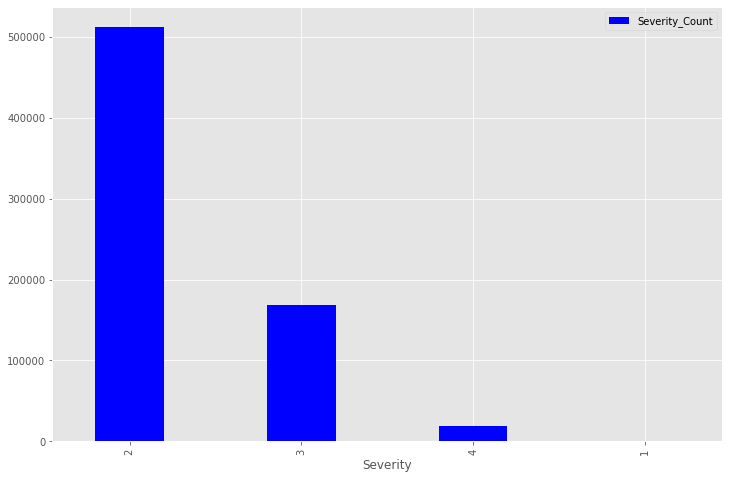

In [82]:
%matplotlib inline 
import matplotlib as mpl

df_percentage = round(df_sev.div(df_sev.sum(1), axis=0)*100,2)

ax=df_sev.plot(kind='bar',  stacked=False, figsize=(12,8), width=.4,  color='blue') #color=[ '#5cb85c', '#5bc0de', '#d9534f']
"""
ax.set_title("Accident Traffice Delay Count - Severity-wise", fontsize="14")
ax.set_xlabel("Traffic Delay Severity", fontsize=12)
ax.set_ylabel("Accident Count", fontsize=12)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height() + 2, \
            str(i.get_height()), fontsize=12,
                color='black')
"""

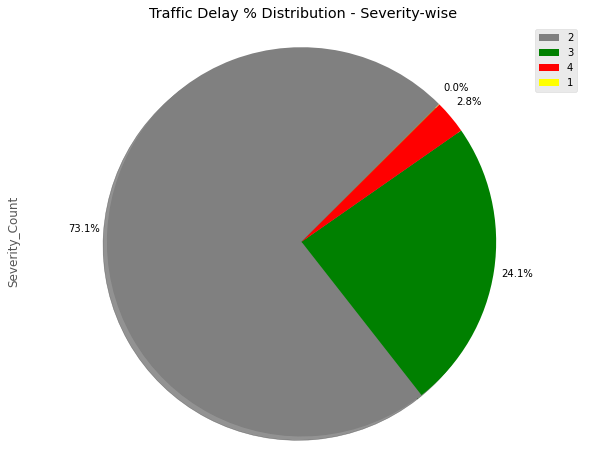

In [84]:
colors = ['gray','green','red', 'yellow']
explode = [0, 0, 0, 0] # ratio for each continent with which to offset each wedge.

df_sev['Severity_Count'].plot(kind='pie',
                            figsize=(10, 8),
                            autopct='%1.1f%%', 
                            startangle=45,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors,  # add custom colors
                            explode=explode # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Traffic Delay % Distribution - Severity-wise') 

plt.axis('equal') 

# add legend
plt.legend(labels=df_sev.index, loc='upper right') 

plt.show()

In [86]:
df_state = accdf.groupby(['Severity','State']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=False)
df_state = df_state[['Severity_Count','State']].set_index('State')
df_state_vis =df_state[df_state['Severity_Count']>5000]
df_state_vis.count()

Severity_Count    34
dtype: int64

In [88]:
df_state_vis.head(10)

,Severity_Count
State,
CA,126973
TX,41851
SC,35537
FL,29054
NC,28592
OR,27596
CA,26442
NY,23098
MN,17573


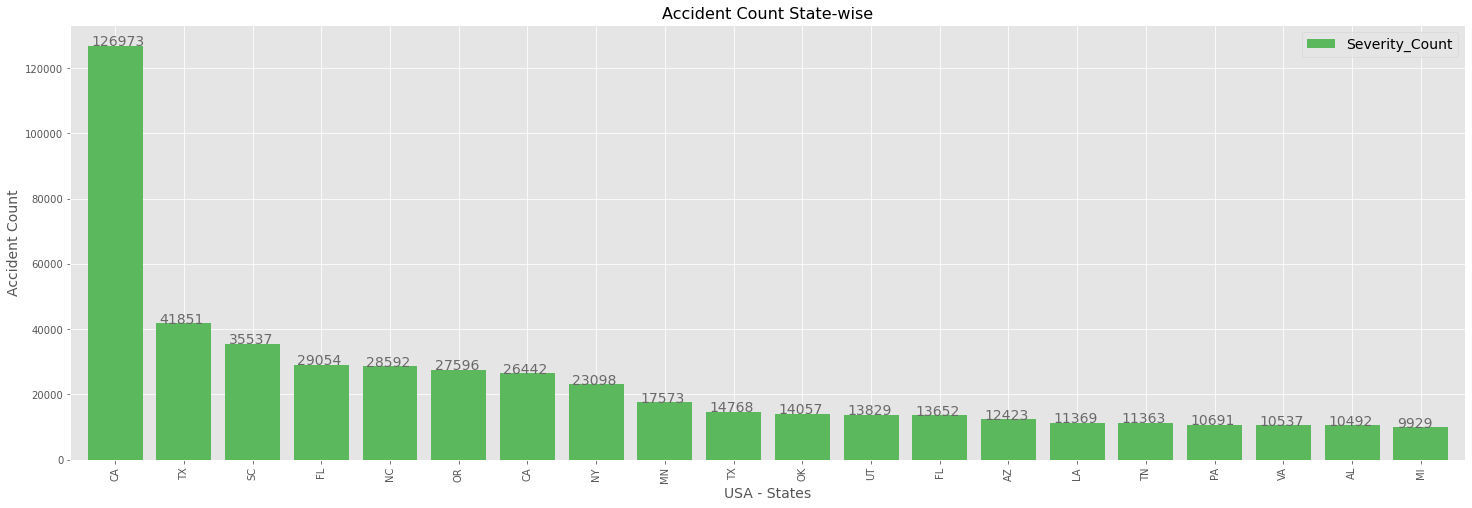

In [89]:
%matplotlib inline 
import matplotlib as mpl
#ds_srvy_df.sort_values(by='Very interested', ascending=False, inplace=True)
df_percentage = round(df_state.div(df_state.sum(1), axis=0)*100,2)

ax=df_state_vis.head(20).plot(kind='bar',  stacked=False, figsize=(25,8), width=.8, color=[ '#5cb85c', '#5bc0de', '#d9534f'])
ax.set_title("Accident Count State-wise", fontsize="16")
ax.set_xlabel("USA - States", fontsize=14)
ax.set_ylabel("Accident Count", fontsize=14)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+1.5, \
            str(i.get_height()), fontsize=14,
                color='dimgrey')


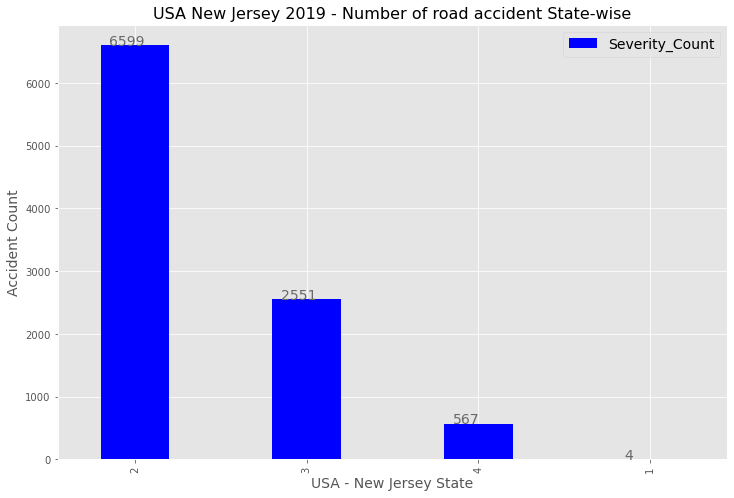

In [91]:
df_nj = accdf[accdf['State']=='NJ']

df_nj_cnt = df_nj.groupby(['Severity']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=False)
df_nj_cnt = df_nj_cnt[['Severity_Count','Severity']].set_index('Severity')
df_percentage = round(df_state.div(df_state.sum(1), axis=0)*100,2)

ax=df_nj_cnt.plot(kind='bar',  stacked=False, figsize=(12,8), width=.4, color='blue')
ax.set_title("USA New Jersey 2019 - Number of road accident State-wise", fontsize="16")
ax.set_xlabel("USA - New Jersey State", fontsize=14)
ax.set_ylabel("Accident Count", fontsize=14)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+1.5, \
            str(i.get_height()), fontsize=14,
                color='dimgrey')


In [92]:
df_nj_cnt

,Severity_Count
Severity,
2,6599
3,2551
4,567
1,4


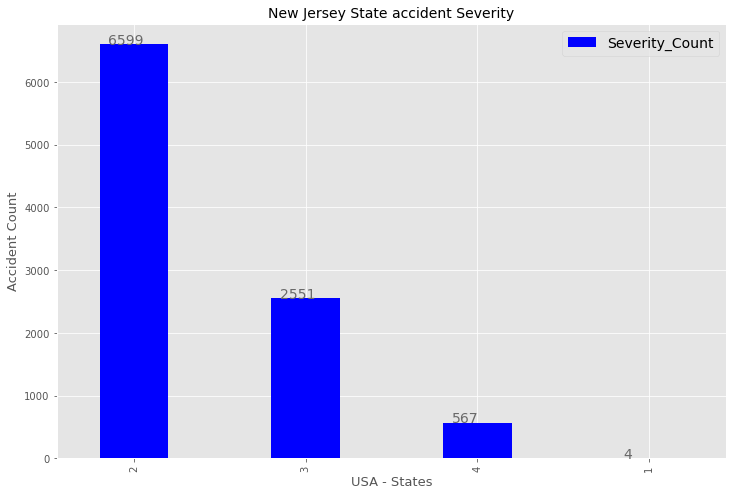

In [93]:
df_nj_data = accdf[accdf['State']=='NJ']
df_nj = df_nj_data.groupby(['Severity','State']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=False)
df_nj = df_nj[df_nj['State']=='NJ'][['Severity','Severity_Count']].reset_index(drop=True)

df_nj = df_nj.set_index('Severity')


#ds_srvy_df.sort_values(by='Very interested', ascending=False, inplace=True)
df_percentage = round(df_state.div(df_state.sum(1), axis=0)*100,2)

ax=df_nj.head(20).plot(kind='bar',  stacked=False, figsize=(12,8), width=.4, color='blue')
ax.set_title("New Jersey State accident Severity", fontsize="14")
ax.set_xlabel("USA - States", fontsize=13)
ax.set_ylabel("Accident Count", fontsize=13)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+1.5, \
            str(i.get_height()), fontsize=14,
                color='dimgrey')


Text(0.5, 1.0, 'New Jersey State - Traffic Delay')

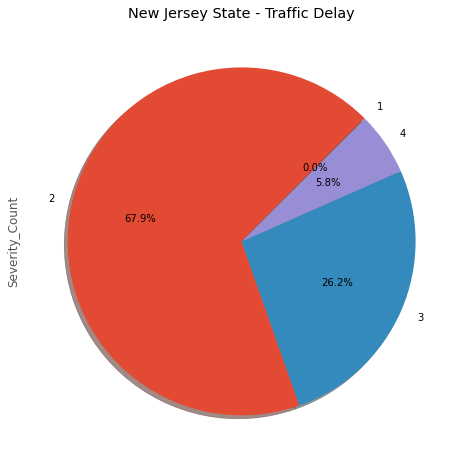

In [94]:
df_nj['Severity_Count'].plot(kind='pie',
                            figsize=(12, 8),
                            autopct='%1.1f%%', # add in percentages
                            startangle=45,     
                            shadow=True,       # add shadow      
                            explode=[0,0,0,0]
                            )
plt.title('New Jersey State - Traffic Delay')

Analyze Traffice Delay Impact with Severity 4 and 3

In [95]:
df_city_cnt = accdf.groupby(['Severity','State','City']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=True)
df_Sev4 = df_city_cnt[(df_city_cnt['Severity']==4) & (df_city_cnt['Severity_Count']>=100)].reset_index(drop=True)
df_Sev4 = df_Sev4[['City','Severity_Count']].sort_values('Severity_Count',ascending=False).set_index('City')


In [96]:
df_Sev4.head(10)

,Severity_Count
City,
Miami,484
Atlanta,436
Seattle,207
Chicago,194
Orlando,183
Houston,183
Jacksonville,166
Portland,127
Los Angeles,126


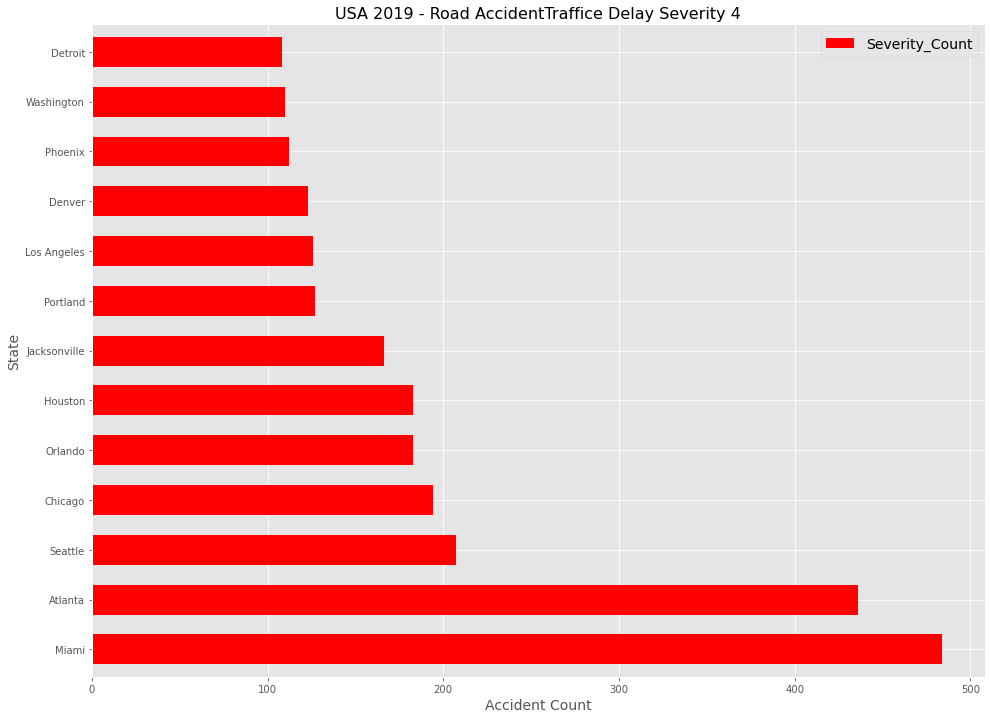

In [97]:

ax=df_Sev4.plot(kind='barh',  stacked=False, figsize=(16,12), width=.6,  color='red') #color=[ '#5cb85c', '#5bc0de', '#d9534f']
ax.set_title("USA 2019 - Road AccidentTraffice Delay Severity 4", fontsize="16")
ax.set_xlabel("Accident Count", fontsize=14)
ax.set_ylabel("State", fontsize=14)
ax.legend(prop={"size":14})



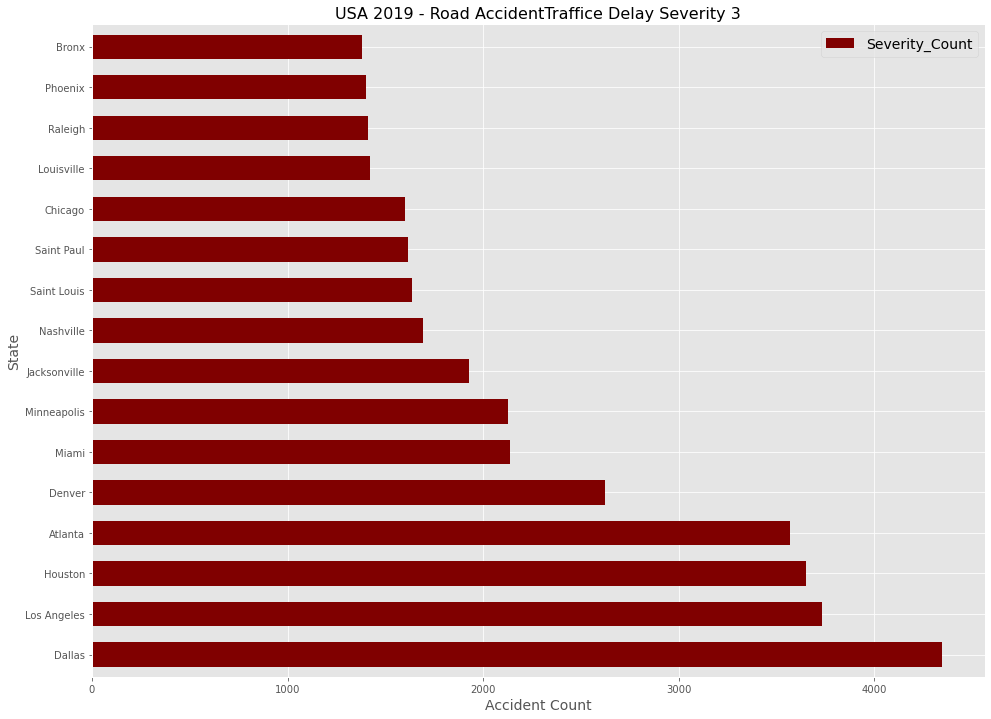

In [98]:
df_Sev3 = df_city_cnt[(df_city_cnt['Severity']==3) & (df_city_cnt['Severity_Count']>=500)].reset_index(drop=True)
df_Sev3 = df_Sev3[['City','Severity_Count']].sort_values('Severity_Count',ascending=False).set_index('City')
ax=df_Sev3.head(16).plot(kind='barh',  stacked=False, figsize=(16, 12), width=.6,  color='maroon') #color=[ '#5cb85c', '#5bc0de', '#d9534f']
ax.set_title("USA 2019 - Road AccidentTraffice Delay Severity 3", fontsize="16")
ax.set_xlabel("Accident Count", fontsize=14)
ax.set_ylabel("State", fontsize=14)
ax.legend(prop={"size":14})

In [99]:
df_Sev3.head(10)


,Severity_Count
City,
Dallas,4348
Los Angeles,3734
Houston,3652
Atlanta,3569
Denver,2621
Miami,2138
Minneapolis,2130
Jacksonville,1927
Nashville,1694


(93, 3)


<AxesSubplot:xlabel='Severity', ylabel='Accident_Hour'>

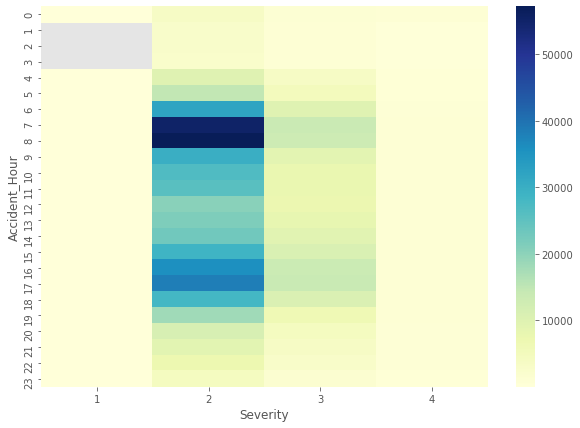

In [100]:
import seaborn as sns
accdf_hr = accdf.groupby(['Start_Hr_Min','Severity']).agg(severity_count_by_Hr=('Severity', 'count')).reset_index().sort_values('severity_count_by_Hr',ascending=False).reset_index(drop=True)
print(accdf_hr.shape)

accdf_hr_hm = accdf_hr[['Start_Hr_Min','Severity','severity_count_by_Hr']]
accdf_hr_hm.rename(columns={'Start_Hr_Min':'Accident_Hour'},inplace=True)
accdf_hr_hm.head(5)
#df_heat_map = pd.pivot_table(df_hr_cnt_hm, values='Severity', index=['Start_Hr_Min'], columns='severity_count_by_Hr')
df_heat_map = pd.pivot_table(accdf_hr_hm, values='severity_count_by_Hr', index=['Accident_Hour'], columns='Severity')
plt.subplots(figsize=(10,7))
sns.heatmap(df_heat_map, cmap="YlGnBu",linewidths=0)

In [102]:
dfo = accdf.groupby(['Severity','Start_Hr_Min']).agg(crossing_count=('Crossing','sum'), junction_count=('Junction','sum'), roundabout_count=('Roundabout','sum'), stop_count=('Stop','sum'),bump_count=('Bump','sum') ).reset_index()
dfo

,Severity,Start_Hr_Min,crossing_count,junction_count,roundabout_count,stop_count,bump_count
0,1,0,0,0,0,0,0
1,1,4,1,0,0,0,0
2,1,5,0,0,0,0,0
3,1,6,2,0,0,0,0
4,1,7,5,0,0,0,0
...,...,...,...,...,...,...,...
88,4,19,53,68,0,14,0
89,4,20,40,65,0,8,0
90,4,21,37,63,0,13,0
91,4,22,50,72,0,18,0


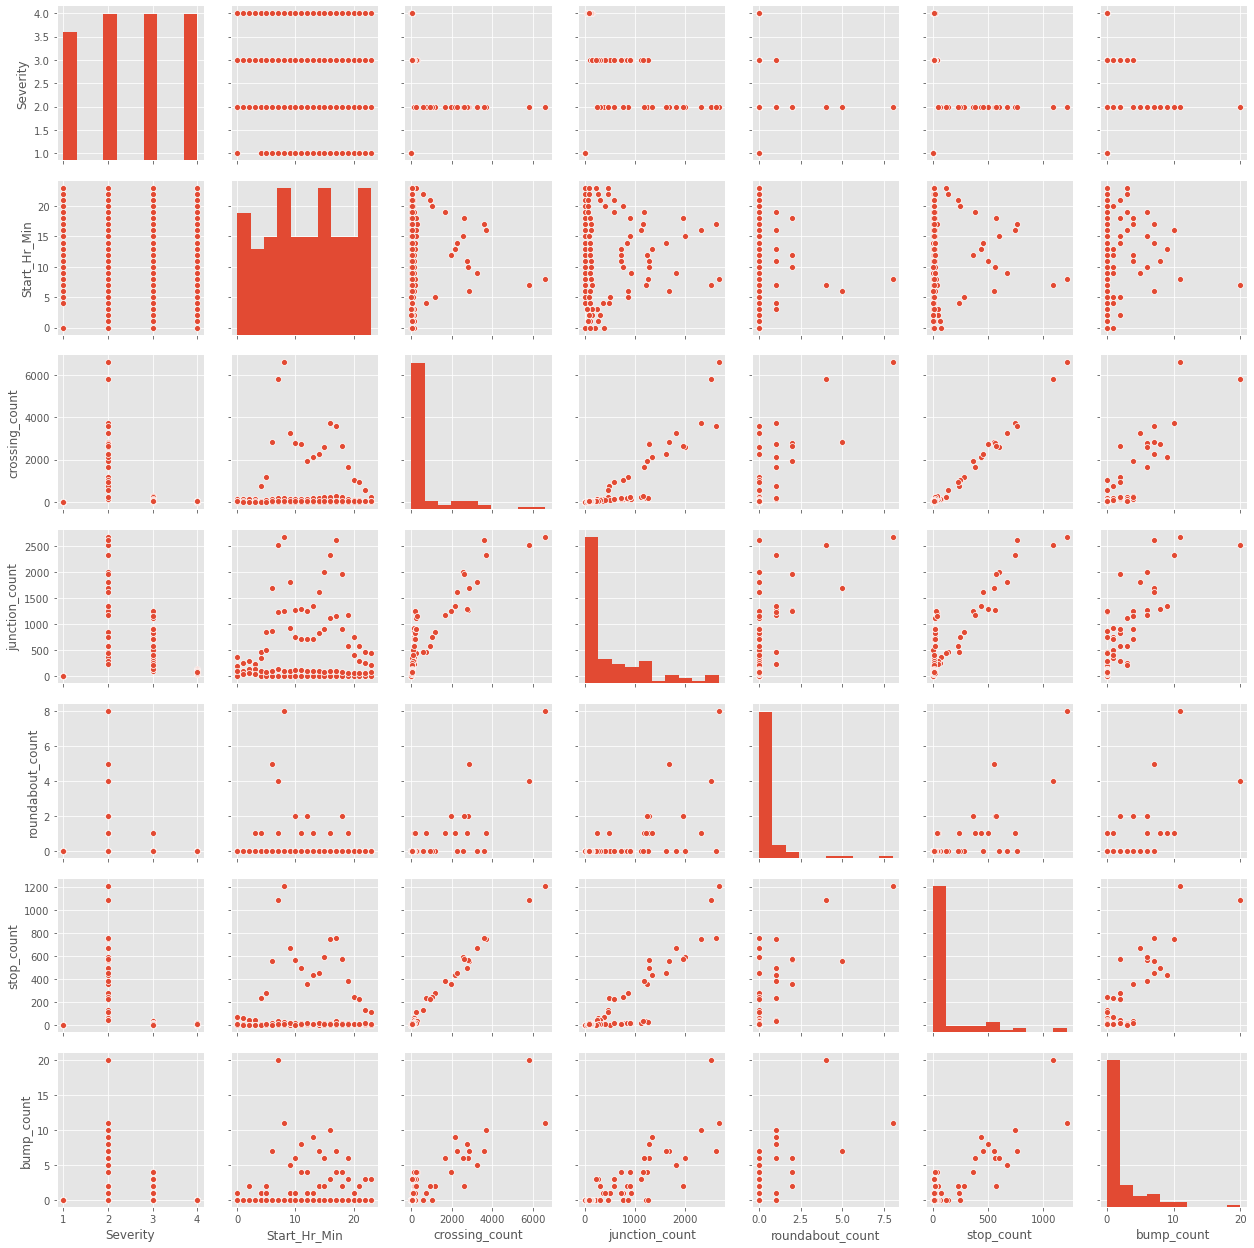

In [103]:
# with regression
sns.pairplot(dfo, kind="scatter")
plt.show()
 


In [104]:
Feature = ['Severity','Start_Lat','Start_Lng','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)',
'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Bump','Crossing','Junction','Roundabout',
'Stop','Start_Hr_Min']

In [105]:
X = np.asarray(pd.concat( [ accdf[Feature], pd.get_dummies(accdf['Weather_Condition']), pd.get_dummies(accdf['Wind_Direction']) ], axis=1) )


In [106]:
y = np.asarray (accdf['Severity'])

In [107]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [108]:
X = preprocessing.StandardScaler().fit(X).transform(X)

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (560205, 126) (560205,)
Test set: (140052, 126) (140052,)


In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [113]:
yhat = LR.predict(X_test)
yhat

array([2, 2, 3, ..., 2, 2, 2])

In [114]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[1.49470782e-03, 9.57255609e-01, 4.12402869e-02, 9.39582320e-06],
       [1.71573640e-03, 9.42931510e-01, 5.53454244e-02, 7.32940922e-06],
       [8.87002051e-04, 3.03300568e-03, 9.79344192e-01, 1.67358001e-02],
       ...,
       [1.42729618e-03, 9.89599419e-01, 8.94195485e-03, 3.13298001e-05],
       [1.46259436e-03, 9.52575121e-01, 4.59536131e-02, 8.67103213e-06],
       [1.78781959e-03, 9.53108387e-01, 4.50947885e-02, 9.00503839e-06]])

In [115]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss



In [116]:
knn_Jaccard = jaccard_similarity_score(y_test, yhat)
print (knn_Jaccard)
knn_f1_score = f1_score(y_test, yhat, average='weighted') 
print (knn_f1_score)
ll_log_loss = log_loss(y_test, yhat_prob)
print (ll_log_loss)

0.9719961157284437
0.9591619156556855
0.05535410335091124


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
